## Imports

In [5]:
!pip install gymnasium matplotlib
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\supaz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Load the environment and hiperparameters

In [6]:
env = gym.make("CartPole-v1")
action_space_size = env.action_space.n # odpowiada za liczbę możliwych akcji (lewo, prawo)

# Parametry uczenia
LEARNING_RATE = 0.1     # współczynnik uczenia (tu wolno ale stabilnie)
DISCOUNT_FACTOR = 0.95  
# ocena przyszłych nagród (wartość bliska 1 oznacza, 
# że przyszłe nagrody są prawie tak samo ważne jak bieżące)
NUM_EPISODES = 20000

# Parametry eksploracji 
epsilon = 1.0          # początkowa wartość epsilon (pełna losowość) 
MIN_EPSILON = 0.01     # minimalna wartość epsilon
EPSILON_DECAY_RATE = NUM_EPISODES / 5  # parametr kontrolujący szybkość zanikania epsilona


## State space discretization

In [7]:
DISCRETE_STATE_SIZE = [20, 20, 20, 20] 
# x x' theta theta'

# ograniczenia wartości stanów
LOWER_BOUNDS = [-4.8, -4.0, -0.418, -4.0] 
UPPER_BOUNDS = [4.8, 4.0, 0.418, 4.0]

# obliczanie kroku dyskretnego stanu dla każdej cechy
discrete_state_step = (np.array(UPPER_BOUNDS) - np.array(LOWER_BOUNDS)) / DISCRETE_STATE_SIZE

# tworzenie Q-tabeli (stan x akcja)
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_STATE_SIZE + [action_space_size]))


def get_discrete_state(state):
    # przekształca ciągły stan na dyskretny indeks do Q-tabeli.
    # korekcja do ustalonych granic
    state_clipped = np.clip(state, LOWER_BOUNDS, UPPER_BOUNDS)
    
    # obliczanie indeksu "kubła"
    discrete_state = (state_clipped - LOWER_BOUNDS) // discrete_state_step
    
    return tuple(discrete_state.astype(int))

## Training loop

$$\mathbf{Q}(s, a) \leftarrow (1 - \alpha) \cdot Q(s, a) + \alpha \cdot \left( R_{t+1} + \gamma \cdot \max_{a'} Q(s_{t+1}, a') \right)$$

In [8]:
ep_rewards = [] # nagrody z epizodów
print(f"Rozpoczęto trening agenta na {NUM_EPISODES} epizodów...")

for episode in range(NUM_EPISODES):
    
    state, _ = env.reset() # resetujemy środowisko na początku każdego epizodu
    discrete_state = get_discrete_state(state) # początkowy stan -> dyskretny
    done = False # czy zakończono epizod
    episode_reward = 0

    while not done:
        
        if random.random() > epsilon: # jak randomowa liczba jest większa niż epsilon -> eksploatacja
            action = np.argmax(q_table[discrete_state])
        else:
            # eksploracja
            action = env.action_space.sample()

        # wykonujemy akcję
        new_state, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        
        done = terminated or truncated  # terminated -> upadła, truncated -> koniec czasu
        episode_reward += reward

        # aktualizacja Q-tabeli
        if not done:
            max_future_q = np.max(q_table[new_discrete_state]) # maksymalna przyszła wartość Q
            current_q = q_table[discrete_state + (action,)] # bieżąca wartość Q
            
            # wzór Bellmana
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT_FACTOR * max_future_q)
            q_table[discrete_state + (action,)] = new_q # aktualizacja Q-wartości
        
        discrete_state = new_discrete_state # przejście do nowego stanu

    ep_rewards.append(episode_reward) # zapis nagrody z epizodu

    # aktualizacja epsilona
    if episode % EPSILON_DECAY_RATE == 0 and epsilon > MIN_EPSILON:
        epsilon = max(MIN_EPSILON, epsilon - (1.0 / EPSILON_DECAY_RATE))
        
    if episode % 1000 == 0 and episode > 0:
        print(f"Epizod: {episode}/{NUM_EPISODES}. Średnia nagroda z ostatnich 1000: {np.mean(ep_rewards[-1000:]):.2f}")

env.close()


Rozpoczęto trening agenta na 20000 epizodów...
Epizod: 1000/20000. Średnia nagroda z ostatnich 1000: 22.56
Epizod: 2000/20000. Średnia nagroda z ostatnich 1000: 21.95
Epizod: 3000/20000. Średnia nagroda z ostatnich 1000: 22.16
Epizod: 4000/20000. Średnia nagroda z ostatnich 1000: 21.70
Epizod: 5000/20000. Średnia nagroda z ostatnich 1000: 21.72
Epizod: 6000/20000. Średnia nagroda z ostatnich 1000: 21.92
Epizod: 7000/20000. Średnia nagroda z ostatnich 1000: 22.69
Epizod: 8000/20000. Średnia nagroda z ostatnich 1000: 22.34
Epizod: 9000/20000. Średnia nagroda z ostatnich 1000: 22.89
Epizod: 10000/20000. Średnia nagroda z ostatnich 1000: 22.76
Epizod: 11000/20000. Średnia nagroda z ostatnich 1000: 22.20
Epizod: 12000/20000. Średnia nagroda z ostatnich 1000: 22.64
Epizod: 13000/20000. Średnia nagroda z ostatnich 1000: 22.49
Epizod: 14000/20000. Średnia nagroda z ostatnich 1000: 22.71
Epizod: 15000/20000. Średnia nagroda z ostatnich 1000: 22.73
Epizod: 16000/20000. Średnia nagroda z ostatnic

## Learning results

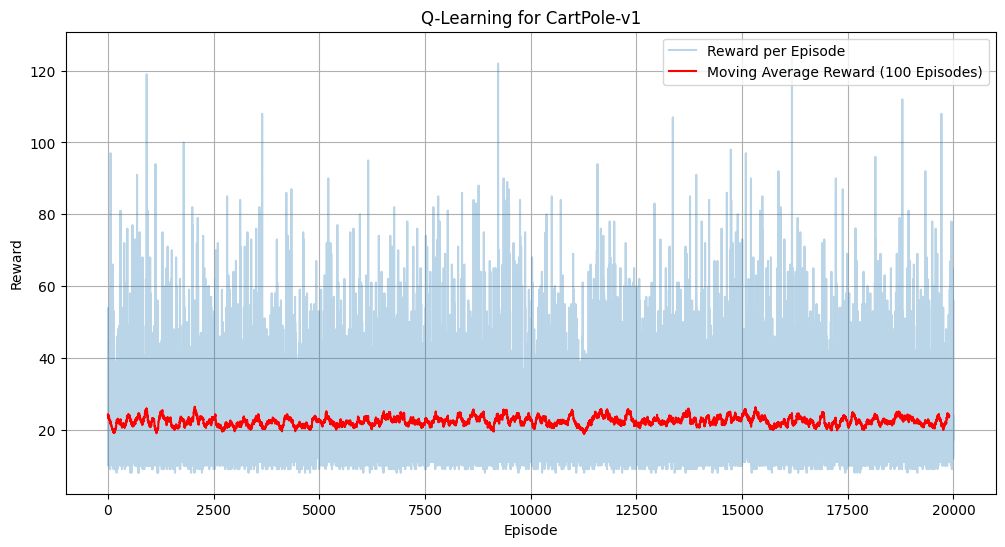


Zakończono Trening!
Średnia nagroda z ostatnich 100 epizodów: 23.81


In [9]:
N = 100 # okno kroczącej średniej
moving_avg = np.convolve(ep_rewards, np.ones((N,))/N, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(ep_rewards, alpha=0.3, label='Reward per Episode')
plt.plot(moving_avg, label=f'Moving Average Reward ({N} Episodes)', color='red')
plt.title('Q-Learning for CartPole-v1')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend()
plt.grid(True)
plt.show()

print("\nZakończono Trening!")
print(f"Średnia nagroda z ostatnich 100 epizodów: {np.mean(ep_rewards[-100:]):.2f}")

## Simulation in pygame

In [ ]:
!pip install pygame

In [ ]:

env_demo = gym.make("CartPole-v1", render_mode="human")
demo_episodes = 5
final_scores = []

print("\nUruchamianie wytrenowanego agenta")

for episode in range(demo_episodes):
    state, _ = env_demo.reset()
    discrete_state = get_discrete_state(state)
    done = False
    score = 0
    
    while not done:
        # w trybie demonstracji zawsze bierzemy najlepszą akcję
        action = np.argmax(q_table[discrete_state])
        
        # wykonanie akcji
        new_state, reward, terminated, truncated, _ = env_demo.step(action)
        discrete_state = get_discrete_state(new_state)
        done = terminated or truncated
        score += reward
    
    final_scores.append(score)
    print(f"Demo {episode+1}: Wynik: {score}")

env_demo.close()



--- Uruchamianie Wytrenowanego Agenta (DEMONSTRACJA) ---
Epizod demonstracyjny 1: Wynik (kroki): 188.0
Epizod demonstracyjny 2: Wynik (kroki): 213.0
Epizod demonstracyjny 3: Wynik (kroki): 235.0
Epizod demonstracyjny 4: Wynik (kroki): 133.0
Epizod demonstracyjny 5: Wynik (kroki): 152.0
Średnia nagroda demonstracyjna (5 epizodów): 184.20
